# How-to: Compute range-defined quasi-vertical profiles

Daniel Sanchez-Rivas<sup>1</sup> and Miguel A. Rico-Ramirez<sup>1</sup>

<sup>1</sup>Department of Civil Engineering, University of Bristol, Bristol, BS8 1TR, United Kingdom

**This notebook describes the process for generating RD-QVPs (adapted from the methodology proposed by Tobin, D. M. and Kumjian, M. R., 2017).**

### Import relevant packages

In [1]:
import datetime as dt
import os
import numpy as np
import towerpy as tp
import cartopy.crs as ccrs
from tqdm import tqdm

%matplotlib notebook


You are using the Towerpy framework, an open source library for
working with polarimetric weather radar data.

If you find our work useful for your research, please consider citing our
following publication:

https://doi.org/10.1016/j.envsoft.105746.2023



### Define working directory, radar site and other parameters

In [2]:
RSITE = 'dudwick'
WDIR = '../../../datasets/'

plot_methods = False

We'll need a list containing the path and names of the files corresponding to each elevation used to compute the RD-QVPs.

In [3]:
SCANS_ELEVS = ['spel1', 'spel2', 'spel3', 'spel4']
# SCANS_ELEVS = ['lpel1', 'lpel2', 'lpel3', 'lpel4']

lfiles_elevs = [f'{WDIR}{RSITE}/2020/spel1/metoffice-c-band-rain-radar_dudwick_202010031811_raw-dual-polar-augzdr-sp-el1.dat',
                f'{WDIR}{RSITE}/2020/spel2/metoffice-c-band-rain-radar_dudwick_202010031811_raw-dual-polar-augzdr-sp-el2.dat',
                f'{WDIR}{RSITE}/2020/spel3/metoffice-c-band-rain-radar_dudwick_202010031810_raw-dual-polar-augzdr-sp-el3.dat',
                f'{WDIR}{RSITE}/2020/spel4/metoffice-c-band-rain-radar_dudwick_202010031810_raw-dual-polar-augzdr-sp-el4.dat'
               ]

### We initialise one towerpy object per each elevation scan.

In [4]:
# Initialise the towerpy's objects.
rdata = [tp.io.ukmo.Rad_scan(i, RSITE) for i in lfiles_elevs]

# Read-in the data
[robj.ppi_ukmoraw(exclude_vars=['W [m/s]', 'SQI [-]', 'CI [dB]'])
 for c, robj in enumerate(rdata)]

# Create a georeference grid for each object.
[robj.ppi_ukmogeoref() for c, robj in enumerate(rdata)]

[None, None, None, None]

### Computation of the Signal-to-Noise-Ratio

We use the signalnoiseratio function to compute the Signal-to-Noise-Ratio (SNR) (in dB) and discard data using a reference noise value.

In [5]:
rsnr = [tp.eclass.snr.SNR_Classif(robj) for robj in rdata]
[robj.signalnoiseratio(rdata[c].georef, rdata[c].params, rdata[c].vars,
                       min_snr=55, data2correct=rdata[c].vars,
                       plot_method=plot_methods)
 for c, robj in enumerate(rsnr)]

[None, None, None, None]

### Clutter classification

As we are working with low-elevation scans, we use the clutter_id function to identify clutter echoes. This function is based on the methodology proposed by Rico-Ramirez, M. A. and Cluckie, I. D., 2008.

In [6]:
rnme = [tp.eclass.nme.NME_ID(robj) for robj in rsnr]
[robj.clutter_id(rdata[c].georef, rdata[c].params, rsnr[c].vars,
                 binary_class=159, data2correct=rsnr[c].vars,
                 plot_method=plot_methods)
 for c, robj in enumerate(tqdm(rnme, desc='NME_ID'))]

NME_ID: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.63it/s]

Clutter classification running time: 0.058 sec.
Clutter classification running time: 0.044 sec.
Clutter classification running time: 0.037 sec.
Clutter classification running time: 0.029 sec.


[None, None, None, None]

### RD-QVPs computation

We use the pol_rdqvps function to compute the RD-QVPs. For this function, we set spec_range=25. This is the specified range (from the radar) from which all elevation data will be confined within the cylindrical volume.

Note that this and other parameters can be modified in this function:

In [7]:
help(tp.profs.polprofs.PolarimetricProfiles.pol_rdqvps)

Help on function pol_rdqvps in module towerpy.profs.polprofs:

pol_rdqvps(self, rscans_georef, rscans_params, rscans_vars, valid_gates=30, thlds='default', power_param1=0, power_param2=2, spec_range=50, vert_res=2, r0=None, qvps_height_method='bh', plot_method=False)
    Generate RD-QVPs of polarimetric variables.
    
    Parameters
    ----------
    rscans_georef : list
        List of objects containing the georeference of the PPI scans.
    rscans_params : list
        List of objects containing Radar technical details.
    rscans_vars : lost
        List of objects containing radar variables used to generate the
        RD-QVPs.
    valid_gates : int, optional
        Number of valid gates (or azimuths) along the radial.
        The default is 30, according to [1]_.
    thlds : dict containing 2-element tuple, optional
        Thresholds [min, max] of radar variables used to discard gates
        in the azimuthal averaging. The default are: ZH [dBZ] > -10 and
        rhoHV > 0.6,

<IPython.core.display.Javascript object>


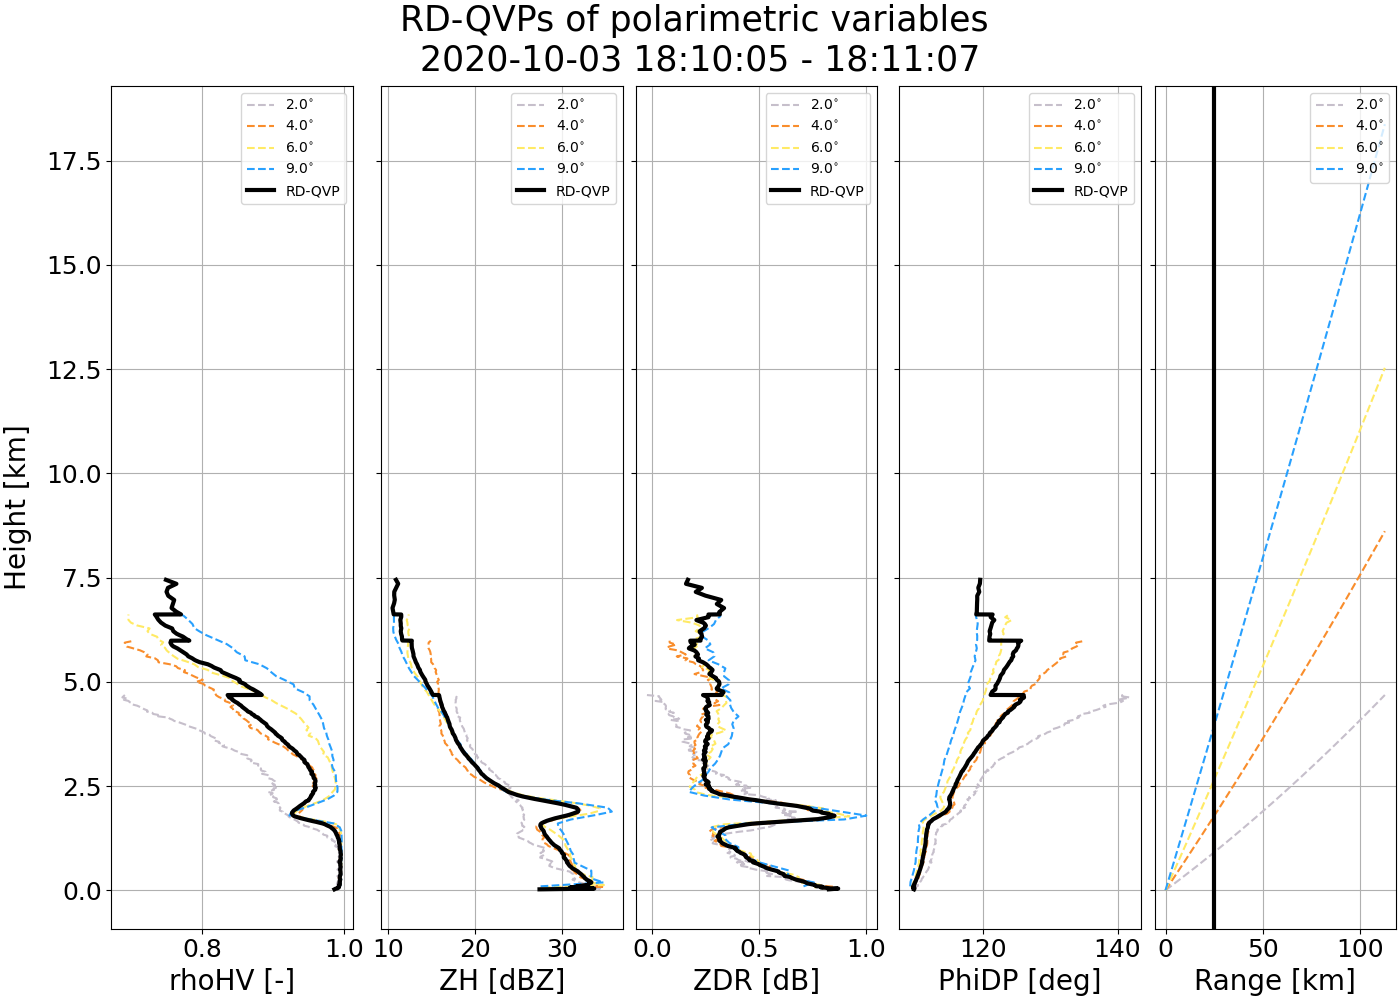

RD-QVPS running time: 0.404 sec.


In [8]:
rdqvps = tp.profs.polprofs.PolarimetricProfiles(rnme)
rdqvps.pol_rdqvps([i.georef for i in rdata], [i.params for i in rdata],
                  [i.vars for i in rnme],
                  spec_range=25, plot_method=True)

RD-QVPs can be used (among many other applications) as input for the melting layer detection algorithm!

### Melting layer height detection

We'll run the method proposed by Sanchez-Rivas, D. and Rico-Ramirez, M. A. (2021) to detect the signatures of the ML within the RD-VPs.

<IPython.core.display.Javascript object>


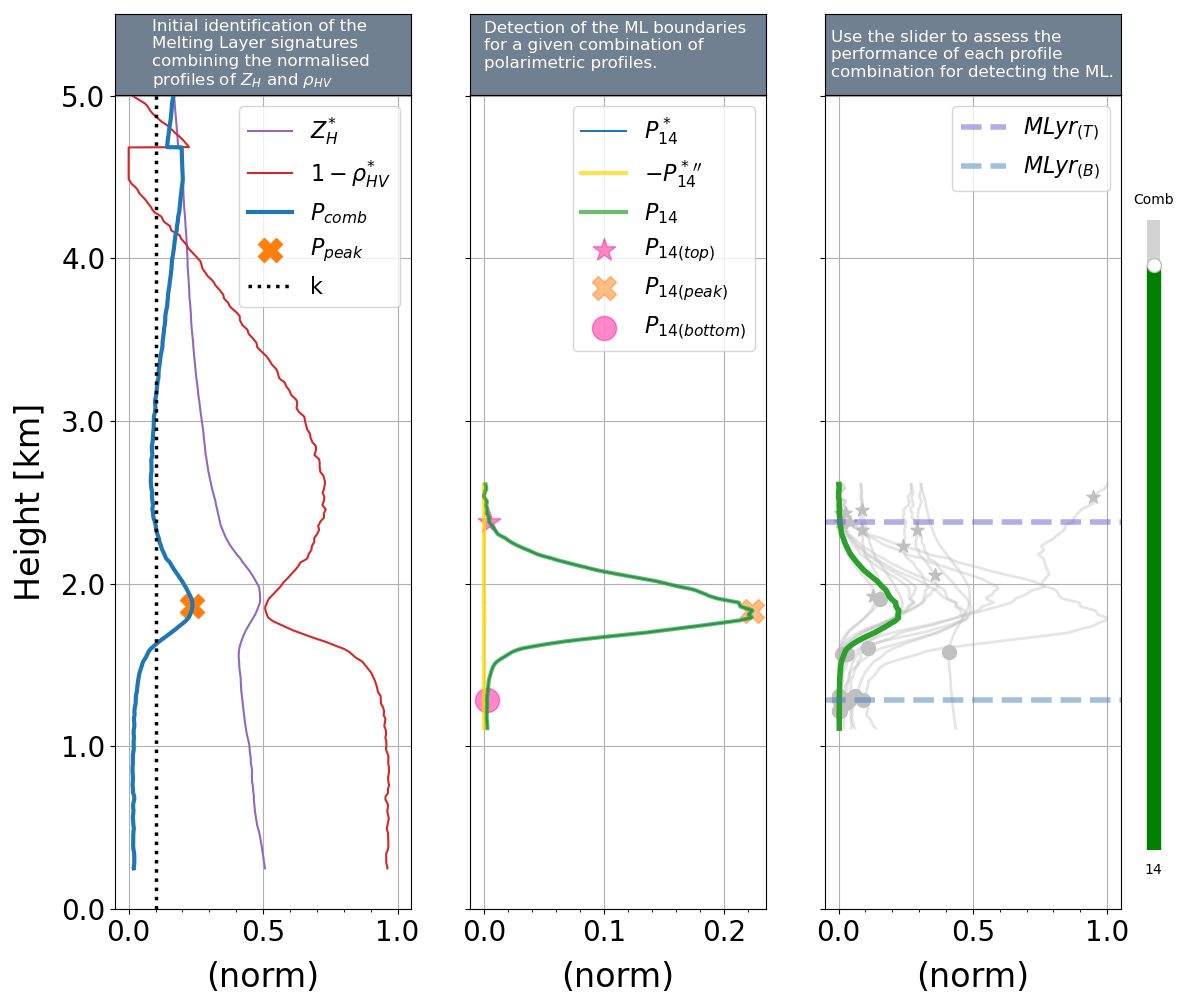

In [9]:
rmlyr = tp.ml.mlyr.MeltingLayer(rdqvps)
rmlyr.ml_detection(rdqvps, min_h=0.25, comb_id=14, param_k=0.1, plot_method=True)

In [10]:
rmlyr.ml_top

2.382

In [11]:
rmlyr.ml_bottom

1.286

## References

[1] Met Office (2003): Met Office Rain Radar Data from the NIMROD System. NCAS British Atmospheric Data Centre, 2022. http://catalogue.ceda.ac.uk/uuid/82adec1f896af6169112d09cc1174499

[2] Rico-Ramirez, M. A., & Cluckie, I. D. (2008). Classification of ground clutter and anomalous propagation using dual-polarization weather radar. IEEE Transactions on Geoscience and Remote Sensing, 46(7), 1892-1904. https://doi.org/10.1109/TGRS.2008.916979

[3] Sanchez-Rivas, D. and Rico-Ramirez, M. A. (2021), "Detection of the melting level with polarimetric weather radar" in Atmospheric Measurement Techniques Journal, Volume 14, issue 4, pp. 2873–2890, 13 Apr 2021 https://doi.org/10.5194/amt-14-2873-2021

[4] Tobin, D. M., & Kumjian, M. R. (2017). Polarimetric Radar and Surface-Based Precipitation-Type Observations of Ice Pellet to Freezing Rain Transitions, Weather and Forecasting, 32(6), 2065-2082. https://doi.org/10.1175/WAF-D-17-0054.1